# **1. Introduction**

- **Objective :** To Create a predictive model to classify whether a person is running or walking based on the given predictor variables.
- **Dataset :** We are using reduced dataset from original Walk or Run dataset. Total 88588 records are available.

# **2. Importing Neccessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import f1_score,accuracy_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# **3. Load Data**

In [2]:
data = pd.read_csv('walkrun.csv')
data.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,30-06-2017,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,30-06-2017,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,30-06-2017,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,30-06-2017,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,30-06-2017,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


# **4.Basic Checks**

In [3]:
data.info(),data.describe(),data.describe(include='O')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88588 entries, 0 to 88587
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            88588 non-null  object 
 1   time            88588 non-null  object 
 2   username        88588 non-null  object 
 3   wrist           88588 non-null  int64  
 4   activity        88588 non-null  int64  
 5   acceleration_x  88588 non-null  float64
 6   acceleration_y  88588 non-null  float64
 7   acceleration_z  88588 non-null  float64
 8   gyro_x          88588 non-null  float64
 9   gyro_y          88588 non-null  float64
 10  gyro_z          88588 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 7.4+ MB


(None,
               wrist      activity  acceleration_x  acceleration_y  \
 count  88588.000000  88588.000000    88588.000000    88588.000000   
 mean       0.522170      0.500801       -0.074811       -0.562585   
 std        0.499511      0.500002        1.009299        0.658458   
 min        0.000000      0.000000       -5.350500       -3.299000   
 25%        0.000000      0.000000       -0.381800       -1.033500   
 50%        1.000000      1.000000       -0.059500       -0.759100   
 75%        1.000000      1.000000        0.355500       -0.241775   
 max        1.000000      1.000000        5.603300        2.668000   
 
        acceleration_z        gyro_x        gyro_y        gyro_z  
 count    88588.000000  88588.000000  88588.000000  88588.000000  
 mean        -0.313956      0.004160      0.037203      0.022327  
 std          0.486815      1.253423      1.198725      1.914423  
 min         -3.753800     -4.430600     -7.464700     -9.480000  
 25%         -0.376000    

- Total reocrds - 88588
- No of independent variables - 10
- No of dependent variables - 1(Activity)
- No null values present in the dataset.

# **5. EDA**

**Context :** The project aims to predict user activity(walking or running) based on the data collected from wearble devices.

## **5.1 Date**

In [4]:
data.date.unique()

array(['30-06-2017', '10-07-2017', '11-07-2017', '15-07-2017',
       '16-07-2017', '17-07-2017', '01-07-2017', '02-07-2017',
       '04-07-2017', '06-07-2017', '07-07-2017', '09-07-2017'],
      dtype=object)

In [5]:
data.date.value_counts()

,count
date,
16-07-2017,20480
17-07-2017,11365
06-07-2017,11357
15-07-2017,7934
09-07-2017,7788
11-07-2017,6696
10-07-2017,4337
01-07-2017,4201
30-06-2017,3992


- Date & time provide timestamp of the data collected over a period of time. Which can be used to analyse the period over which data is collected. It also gives trends & patterns over the period of time.
- Total 12 dates are available in dataset
- 50% data available on 6,16 & 17 dates.

## **5.2 Username**

In [6]:
data.username.unique()

array(['viktor'], dtype=object)

- This data could be useful to provide personalized activity recommendations
- Since the whole data is for user viktor, Column can be removed from further processing

## **5.3 Wrist**

In [7]:
data.wrist.unique()

array([0, 1])

In [8]:
data.wrist.value_counts()

,count
wrist,
1,46258
0,42330


- This data denotes where the sensor is placed Left hand (0) or Right hand(1).
- This may influence the sensor data collected based on motion between hands.

## **5.4 Activity**

In [9]:
data.activity.unique()

array([0, 1])

In [10]:
data.activity.value_counts()

,count
activity,
1,44365
0,44223


- This is Target variable.
- Activity is physical activity performed during recording data.
- 0 for walk & 1 for Run

## **5.5 Accelerometer & Gyroscope**

- These 2 data can be useful to get information like how fast device is moving and in which direction.
- Accelerometer detects linear acceleration along an x,y,z axis & gyroscope measures the rate of rotation of a device around the x, y and z axes, and reports the values in radians per second. This rate of rotation is also known as angular velocity.

## **5.6 Univariate Analysis**

- In Univariate Analysis, we will focus individual variables to understand the characteristics.

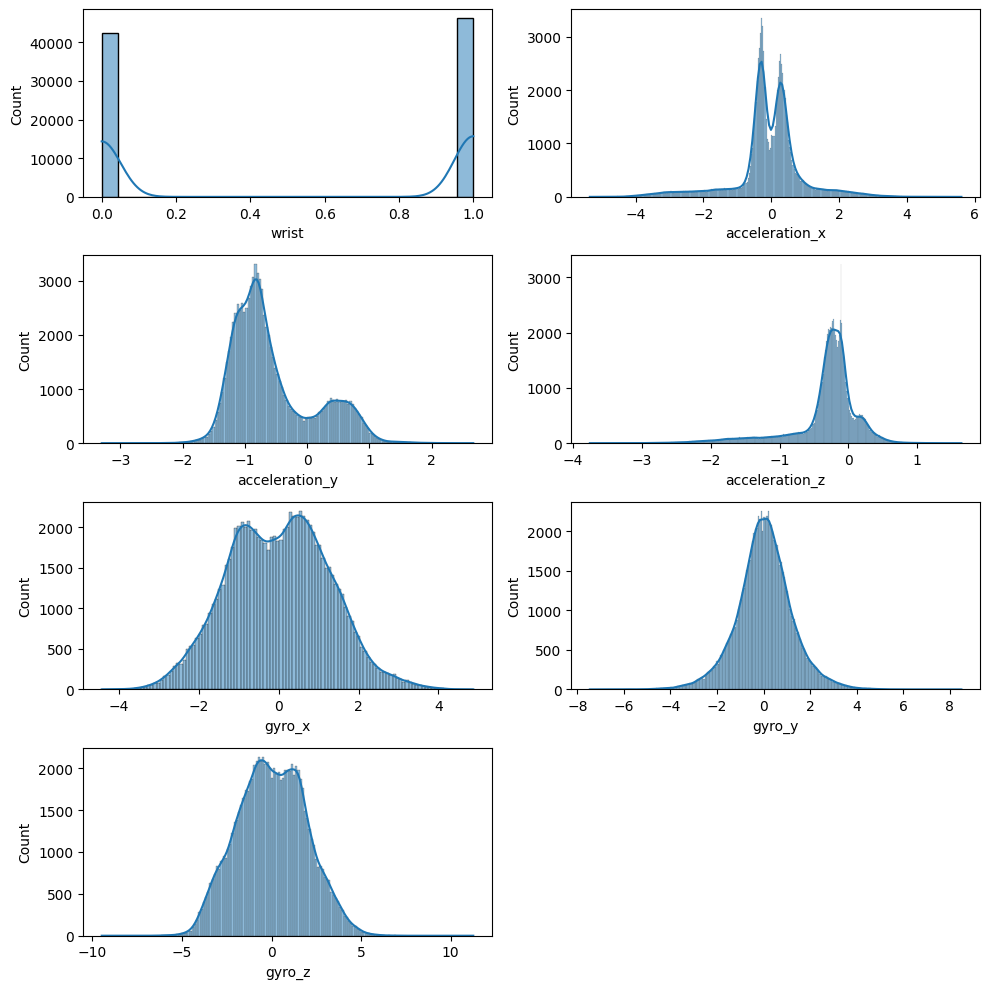

In [11]:
plt.figure(figsize=(10,10))
n = 1
for i in data.drop(['date','time','username','activity'],axis=1):
    plt.subplot(4,2,n)
    sns.histplot(x=i,data=data,kde=True)
    n += 1
plt.tight_layout()

# **6. Checking and handling Outliers**

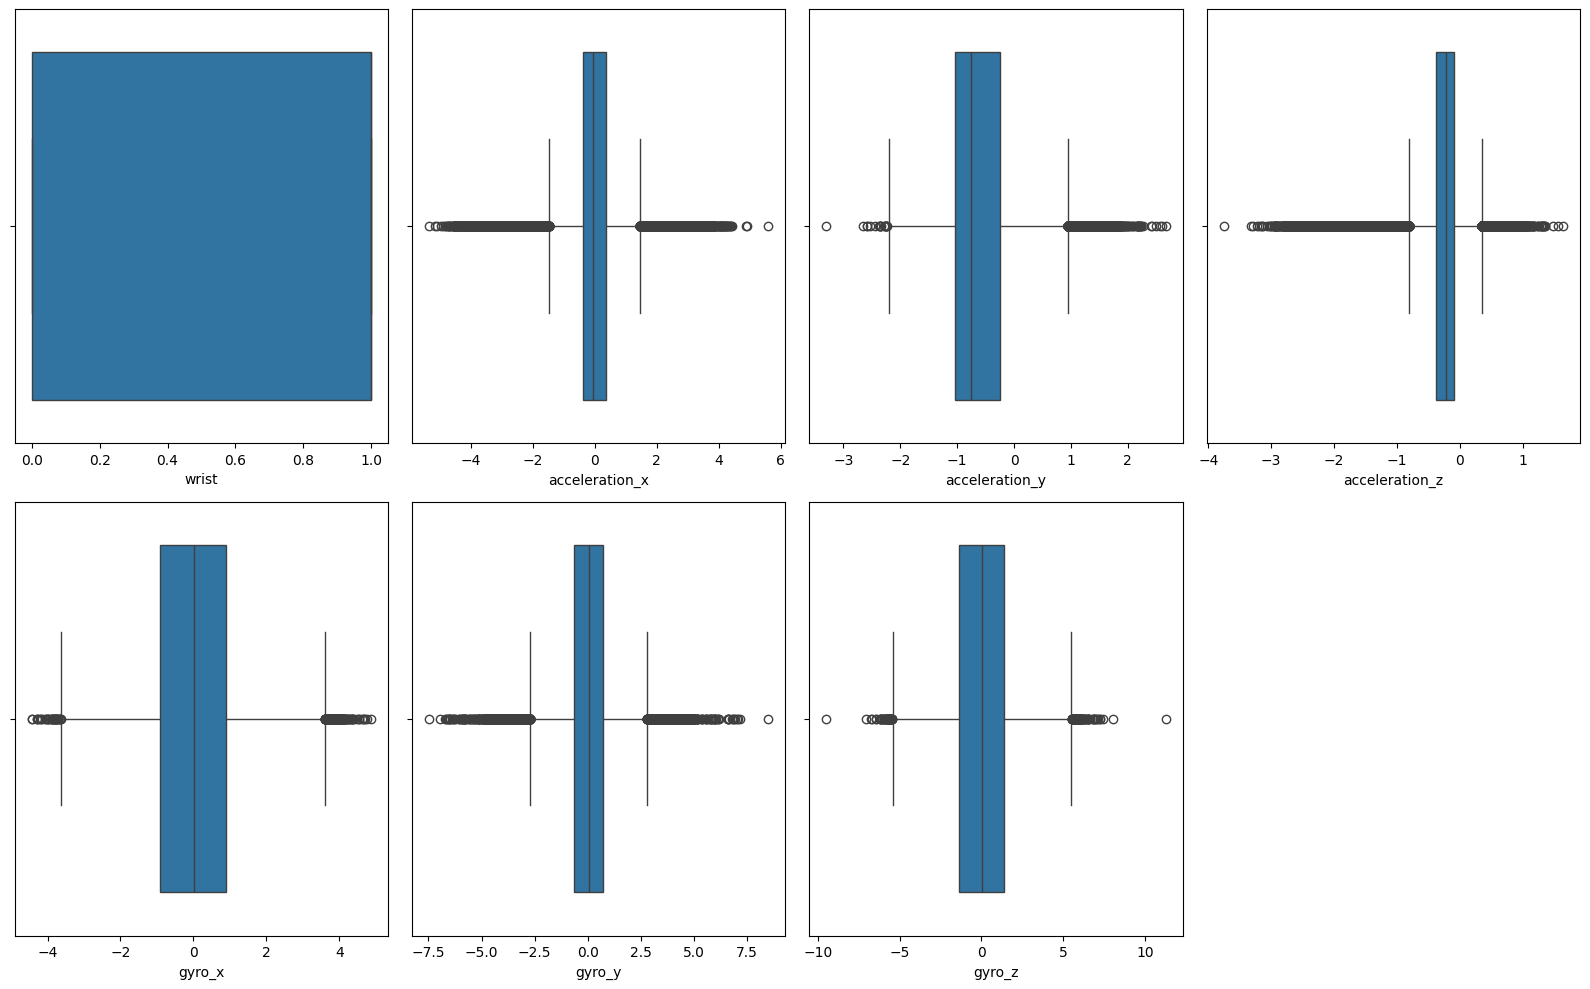

In [ ]:
plt.figure(figsize=(16,10))
n = 1
for i in data.drop(['date','time','username','activity'],axis=1):
    plt.subplot(2,4,n)
    sns.boxplot(x=i,data=data)
    n += 1
plt.tight_layout()

- Since the gyroscope & acclerometer data is crucial for predicting the activity(walk/run). Skipping the outlier process.

# **7. Scaling & Transformation**

In [ ]:
processedData = data.drop(['date','time','username'],axis=1)
processedData

,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922
...,...,...,...,...,...,...,...,...
88583,0,0,0.3084,-0.8376,-0.1327,0.4823,2.0124,0.6048
88584,0,0,0.4977,-1.0027,-0.4397,0.1022,-1.2565,-0.0761
88585,0,0,0.4587,-1.1780,-0.2827,-1.4500,-0.2792,-1.2616
88586,0,0,0.2590,-0.8582,-0.0759,-1.5165,0.4560,-1.7755


In [ ]:
cols = ['acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y','gyro_z']
stdenc = StandardScaler()
processedData[cols] = pd.DataFrame(stdenc.fit_transform(processedData[cols]))

In [ ]:
processedData.describe()

,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
count,88588.000000,88588.000000,8.858800e+04,8.858800e+04,8.858800e+04,8.858800e+04,8.858800e+04,8.858800e+04
mean,0.522170,0.500801,-6.159941e-17,1.052323e-16,-2.053314e-17,-6.416605e-18,-2.566642e-18,-3.529133e-17
std,0.499511,0.500002,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,0.000000,0.000000,-5.227113e+00,-4.155816e+00,-7.066059e+00,-3.538140e+00,-6.258270e+00,-4.963573e+00
25%,0.000000,0.000000,-3.041620e-01,-7.151825e-01,-1.274488e-01,-7.378719e-01,-5.689646e-01,-7.142934e-01
50%,1.000000,1.000000,1.517044e-02,-2.984490e-01,1.909492e-01,1.159994e-02,1.749150e-03,-8.058497e-03
75%,1.000000,1.000000,4.263494e-01,4.872167e-01,4.684689e-01,7.057829e-01,5.810345e-01,7.186919e-01
max,1.000000,1.000000,5.625831e+00,4.906315e+00,4.014395e+00,3.885414e+00,7.058203e+00,5.873276e+00


In [ ]:
x = processedData.drop(['activity'],axis=1)
x

,wrist,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,0,0.336683,-0.332316,0.629311,-0.050391,-0.003924,-1.541949
1,0,0.740133,-0.851562,0.163423,-0.143496,-0.013684,0.054624
2,0,0.509972,-1.395867,0.793235,-0.729734,0.057642,-1.284481
3,0,0.374432,-0.379548,0.827334,0.092339,-0.372984,-1.544039
4,0,0.551090,-0.559819,0.718668,0.038726,0.334271,1.290147
...,...,...,...,...,...,...,...
88583,0,0.379683,-0.417668,0.372333,0.381469,1.647757,0.304257
88584,0,0.567240,-0.668406,-0.258300,0.078218,-1.079239,-0.051414
88585,0,0.528599,-0.934636,0.064206,-1.160158,-0.263951,-0.670664
88586,0,0.330738,-0.448953,0.489011,-1.213213,0.349370,-0.939101


In [ ]:
y = processedData.activity
y

,activity
0,0
1,0
2,0
3,0
4,0
...,...
88583,0
88584,0
88585,0
88586,0


# **8. Correllation**

<Axes: >

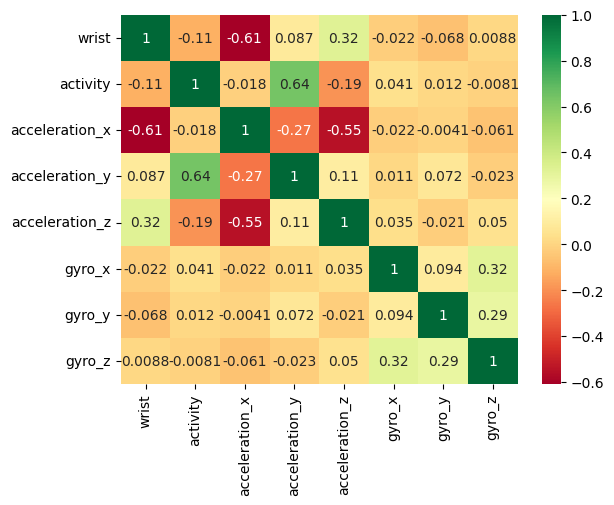

In [ ]:
corr = processedData.corr()
sns.heatmap(corr,cmap= 'RdYlGn', annot=True)

- From the above heat map, we can see there is no high correlation between variables.

# **9. Splitting data**

In [ ]:
# Splitting the data into training and testing
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=16)

In [ ]:
print('x_train',x_train.shape)
print('y_train',y_train.shape)
print('x_test',x_test.shape)
print('y_test',y_test.shape)

x_train (70870, 7)
y_train (70870,)
x_test (17718, 7)
y_test (17718,)


# **10. Models**

## **10.1 Define Model**

In [ ]:
F1_Score = pd.DataFrame(columns=['Model_Name', 'F1Score']) # To store the f1 score of each model

Acc_Score = pd.DataFrame(columns=['Model_Name', 'AccScore']) # To store the Accuracy score of each model

# Defining model instance
def LoadModel(x_train,x_test,y_train,y_test,modelname,MLmodel,randstate):
    global F1_Score
    global Acc_Score
    modelinit = MLmodel
   # model = modelinit(random_state=rs)
    modelinit.fit(x_train,y_train)
    pred = modelinit.predict(x_test)
    f1score = f1_score(y_test,pred)
    acc_score = accuracy_score(y_test,pred)
    class_report = classification_report(y_test,pred)
    cross_tab = pd.crosstab(y_test,pred)
    model_name = modelinit.__class__.__name__
    if(randstate == False):
        values = pd.DataFrame({
            'Model_Name':[modelname],
            'F1Score':[f1score]
        })
        accvalues = pd.DataFrame({
            'Model_Name':[modelname],
            'AccScore':[acc_score]
        })
        F1_Score = pd.concat([F1_Score,values],ignore_index=True)
        Acc_Score = pd.concat([Acc_Score,accvalues],ignore_index=True)

    return f1score,acc_score,class_report,cross_tab,model_name

# Prints the model metrics after processing
def LoadMetrics(modelname,MLmodel,rs1,randstate = False):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=rs1)
    f1score,acc_score,class_report,cross_tab,model_name = LoadModel(x_train,x_test,y_train,y_test,modelname,MLmodel,randstate)
    if(randstate == False):
        print('Model Name: ',model_name)
        print('\nF1 score->', f1score)
        print('Accuracy Score->',acc_score)
        print('Classification Report\n', class_report)
        print('Cross Tab\n',cross_tab)
    else:
        return f1score

# Comparing to see which random state gives best f1 score
def bestrandstate(modelname,model):
    model = model
    f1 = []
    randi = []
    for i in tqdm(range(1,43)):
        f1score = LoadMetrics(modelname,model,i,True)
        f1.append(f1score)
        randi.append(i)
    print(np.max(f1))
    print(randi[np.argmax(f1)])

#GridSearch model instance
def GridSearch(model,param_grid,rs1):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=rs1)
    grid = GridSearchCV(estimator = model,param_grid = param_grid,scoring = 'accuracy',n_jobs =-1,cv=5,verbose =3)
    grid.fit(x_train,y_train)
    return grid.best_params_

## **10.2 Logistic Regression**

In [ ]:
LoadMetrics('LR',LogisticRegression(random_state=16),16)

Model Name:  LogisticRegression

F1 score-> 0.8499195039055513
Accuracy Score-> 0.8579410768709786
Classification Report
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      8884
           1       0.90      0.81      0.85      8834

    accuracy                           0.86     17718
   macro avg       0.86      0.86      0.86     17718
weighted avg       0.86      0.86      0.86     17718

Cross Tab
 col_0        0     1
activity            
0         8074   810
1         1707  7127


In [ ]:
#bestrandstate(LR_RS,LogisticRegression())
# Results
# 0.8602650546384562
# 28
# 1

In [ ]:
# Applying the best randomstates
LoadMetrics('LR_RS',LogisticRegression(random_state=28),1)

Model Name:  LogisticRegression

F1 score-> 0.8591810694814986
Accuracy Score-> 0.8629642171802686
Classification Report
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      8673
           1       0.90      0.82      0.86      9045

    accuracy                           0.86     17718
   macro avg       0.87      0.86      0.86     17718
weighted avg       0.87      0.86      0.86     17718

Cross Tab
 col_0        0     1
activity            
0         7883   790
1         1638  7407


### **10.2.1 Logistic Regression - Hyperparameter Tuning**

In [ ]:
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga']
# }
# model = LogisticRegression()
# best_params = GridSearch(model,param_grid,28)
# print(best_params)

In [ ]:
# {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

In [ ]:
bestmodel = LogisticRegression(C = 0.1, penalty = 'l2',solver = 'liblinear',random_state=28)
print(bestmodel)
LoadMetrics('LR_HPT',bestmodel,1)

LogisticRegression(C=0.1, random_state=28, solver='liblinear')
Model Name:  LogisticRegression

F1 score-> 0.8595012497820148
Accuracy Score-> 0.8635850547465854
Classification Report
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      8673
           1       0.91      0.82      0.86      9045

    accuracy                           0.86     17718
   macro avg       0.87      0.86      0.86     17718
weighted avg       0.87      0.86      0.86     17718

Cross Tab
 col_0        0     1
activity            
0         7908   765
1         1652  7393


# 10.3 Decision Tree

In [ ]:
LoadMetrics('DT',DecisionTreeClassifier(random_state=16),16)

Model Name:  DecisionTreeClassifier

F1 score-> 0.9841413683733575
Accuracy Score-> 0.9841968619483011
Classification Report
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      8884
           1       0.98      0.98      0.98      8834

    accuracy                           0.98     17718
   macro avg       0.98      0.98      0.98     17718
weighted avg       0.98      0.98      0.98     17718

Cross Tab
 col_0        0     1
activity            
0         8750   134
1          146  8688


In [ ]:
#bestrandstate('DT_RS',DecisionTreeClassifier())
# 0.9860790170771571
# 9

In [ ]:
# Applying the best randomstates
LoadMetrics('DT_RS',DecisionTreeClassifier(),9)

Model Name:  DecisionTreeClassifier

F1 score-> 0.9856772301793165
Accuracy Score-> 0.985664296195959
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      8857
           1       0.99      0.99      0.99      8861

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Cross Tab
 col_0        0     1
activity            
0         8724   133
1          121  8740


### **10.3.1 Decision Tree - Hyper parameter Tuning**

In [ ]:
# param_grid = {
#     'criterion' : ('gini','entropy'),
#     'splitter' : ('best','random'),
#     'max_depth' : (list(range(1,10))),
#     'min_samples_split': [2,3,4,5,6],
#     'min_samples_leaf' : list(range(1,10))
# }
# model = DecisionTreeClassifier()
# best_params = GridSearch(model,param_grid,9)
# print(best_params)

# Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
# {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 3, 'splitter': 'best'}

In [ ]:
bestmodel = DecisionTreeClassifier(criterion = 'entropy', max_depth =9, min_samples_leaf = 3, min_samples_split = 3, splitter = 'best')
print(bestmodel)
LoadMetrics('DT_HPT',bestmodel,1)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=3,
                       min_samples_split=3)
Model Name:  DecisionTreeClassifier

F1 score-> 0.9825186504843558
Accuracy Score-> 0.9822779094705949
Classification Report
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      8673
           1       0.99      0.98      0.98      9045

    accuracy                           0.98     17718
   macro avg       0.98      0.98      0.98     17718
weighted avg       0.98      0.98      0.98     17718

Cross Tab
 col_0        0     1
activity            
0         8580    93
1          221  8824


# **10.4 RandomForest Classifier**

In [ ]:
LoadMetrics('RFC',RandomForestClassifier(random_state=16),16)

Model Name:  RandomForestClassifier

F1 score-> 0.9910491728982551
Accuracy Score-> 0.9910825149565413
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8884
           1       0.99      0.99      0.99      8834

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Cross Tab
 col_0        0     1
activity            
0         8813    71
1           87  8747


In [ ]:
#bestrandstate('RFC_RS',RandomForestClassifier())
# 0.9923449285151413
# 12

In [ ]:
# Applying the best randomstates
LoadMetrics('RFC_RS',RandomForestClassifier(),12)

Model Name:  RandomForestClassifier

F1 score-> 0.9923449285151413
Accuracy Score-> 0.9923241900891748
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8836
           1       0.99      0.99      0.99      8882

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Cross Tab
 col_0        0     1
activity            
0         8767    69
1           67  8815


## **10.4.1 Random Forest Classifier - Hyper parameter Tuning**

In [ ]:
# param_grid = {
#         'n_estimators': [int(x) for x in np.linspace(200,2000,5)],
#         'max_features' : ['sqrt','log2'],
#         'max_depth' : [int(x) for x in np.linspace(10,110,num=5)],
#         'min_samples_split' : [2,3,5],
#         'min_samples_leaf' : [2,4,6,8,10]
# }
# model = RandomForestClassifier()
# best_params = GridSearch(model,param_grid,12)
# print(best_params)

In [ ]:
bestmodel = RandomForestClassifier(n_estimators = 400,max_features = 'log2',max_depth=10,min_samples_split = 5,min_samples_leaf=20)
print(bestmodel)
LoadMetrics('RFC_HPT',bestmodel,12)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=20,
                       min_samples_split=5, n_estimators=400)
Model Name:  RandomForestClassifier

F1 score-> 0.9851994124957631
Accuracy Score-> 0.9852127779659103
Classification Report
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      8836
           1       0.99      0.98      0.99      8882

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Cross Tab
 col_0        0     1
activity            
0         8736   100
1          162  8720


# **10.5 XGB**

In [ ]:
LoadMetrics('XGB',XGBClassifier(random_state=16),16)

Model Name:  XGBClassifier

F1 score-> 0.9926328913068118
Accuracy Score-> 0.9926628287617113
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8884
           1       0.99      0.99      0.99      8834

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Cross Tab
 col_0        0     1
activity            
0         8830    54
1           76  8758


In [ ]:
#bestrandstate('XGB_RS',XGBClassifier())

# 0.9936161798768431
# 24

In [ ]:
# Applying the best randomstates
LoadMetrics('XGB_RS',XGBClassifier(),24)

Model Name:  XGBClassifier

F1 score-> 0.9936161798768431
Accuracy Score-> 0.9936223050005644
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8859
           1       0.99      0.99      0.99      8859

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Cross Tab
 col_0        0     1
activity            
0         8811    48
1           65  8794


## **10.5.1 XGB - Hyper parameter tuning**

In [ ]:
# param_grid = {'subsample' : [0.5,0.8,1.0],
#     'learning_rate' :[0.01,0.03,0.06,0.1],
#     'max_depth' : [5,6,7,8],
#     'n_estimators' : [50,100,200]
# }
# model = XGBClassifier()
# best_params = GridSearch(model,param_grid,24)
# print(best_params)

# Fitting 5 folds for each of 144 candidates, totalling 720 fits
# {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

In [ ]:
LoadMetrics('XGB_HPT',XGBClassifier(subsample = 0.8 ,learning_rate = 0.1,max_depth=7,n_estimators=200),24)

Model Name:  XGBClassifier

F1 score-> 0.9936751750621188
Accuracy Score-> 0.9936787447793205
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8859
           1       0.99      0.99      0.99      8859

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Cross Tab
 col_0        0     1
activity            
0         8808    51
1           61  8798


# **10.6 ANN**

In [ ]:
LoadMetrics('ANN',MLPClassifier(random_state=16),16)

Model Name:  MLPClassifier

F1 score-> 0.9928539019963702
Accuracy Score-> 0.9928885878767355
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8884
           1       0.99      0.99      0.99      8834

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Cross Tab
 col_0        0     1
activity            
0         8839    45
1           81  8753


In [ ]:
#bestrandstate('ANN_RS',MLPClassifier())

In [ ]:
# Applying the best randomstates
LoadMetrics('ANN_RS',MLPClassifier(random_state=16, max_iter=350),16)

Model Name:  MLPClassifier

F1 score-> 0.9928539019963702
Accuracy Score-> 0.9928885878767355
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8884
           1       0.99      0.99      0.99      8834

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Cross Tab
 col_0        0     1
activity            
0         8839    45
1           81  8753


## 10.6.1 ANN - Hyper Parameter Tuning

In [ ]:
# param_grid = {
#     "learning_rate_init" : [ 0.001,0.005,0.01],
#     "hidden_layer_sizes" : [(100,50,3),(100,100,3)],
#     "activation" : ['identity', 'logistic', 'tanh', 'relu'],
#     "solver" : ['lbfgs', 'sgd', 'adam'],
# }
# model = MLPClassifier(random_state=16,max_iter=350)
# best_params = GridSearch(model,param_grid,16)
# print(best_params)
# ########################
# Fitting 5 folds for each of 72 candidates, totalling 360 fits
# {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 3), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}

In [ ]:
ANNmodel = MLPClassifier(hidden_layer_sizes = (100,100,3),
                         activation='tanh',
                         solver='lbfgs',
                         learning_rate_init = 0.001,
                         max_iter=350,
                         random_state=16
                         )
LoadMetrics('ANN_HPT',ANNmodel,16) # Runs approximately 8 mins

Model Name:  MLPClassifier

F1 score-> 0.9918348831934679
Accuracy Score-> 0.9918726718591263
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8884
           1       0.99      0.99      0.99      8834

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Cross Tab
 col_0        0     1
activity            
0         8828    56
1           88  8746


# **10.7 RNN**

In [ ]:
features = ['wrist','acceleration_x','acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z']
x = data[features].values
y = data['activity'].values

# Reshape the data to fit the LSTM input requirements
x = x.reshape((x.shape[0], 1, x.shape[1]))

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=16)

In [ ]:
# Build the LSTM model

#The Sequential model is a linear stack of layers. It allows you to build a model layer by layer.
model = Sequential()

# LSTM layer is added with 100 units, RELU activation function used to apply to the output of each unit.
# For LSTM layers, the input shape should be (timesteps, features). Here Timesteps =1 & features =7
model.add(LSTM(100, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))

#Adds 1 fully connected dense layer with 10 units & RELU activation function
model.add(Dense(10, activation='relu'))

#Adds 1 fully connected dense layer with 5 units & RELU activation function
model.add(Dense(5, activation='relu'))

#Adds 1 fully connected dense layer with 1 units & Sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)

# Store the accuracy in accvalues DataFrame
accvalues = pd.DataFrame({
            'Model_Name': 'RNN',
            'AccScore':[accuracy]
        })
Acc_Score = pd.concat([Acc_Score,accvalues],ignore_index=True)

Epoch 1/20
2215/2215 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9285 - loss: 0.2102 - val_accuracy: 0.9910 - val_loss: 0.0312
Epoch 2/20
2215/2215 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9907 - loss: 0.0289 - val_accuracy: 0.9912 - val_loss: 0.0283
Epoch 3/20
2215/2215 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9912 - loss: 0.0267 - val_accuracy: 0.9916 - val_loss: 0.0271
Epoch 4/20
2215/2215 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9918 - loss: 0.0238 - val_accuracy: 0.9905 - val_loss: 0.0282
Epoch 5/20
2215/2215 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9927 - loss: 0.0224 - val_accuracy: 0.9923 - val_loss: 0.0246
Epoch 6/20
2215/2215 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9932 - loss: 0.0222 - val_accuracy: 0.9915 - val_loss: 0.0263
Epoch 7/20
2215/2215 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9925 - loss: 0.0229 - val_accuracy: 0.9927 - val_loss: 0.0232
Epoch 8/20
2215/2215 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9927 - loss: 0.02

# **10.7 Results**

## **10.7.1 Visualization of F1 scores**

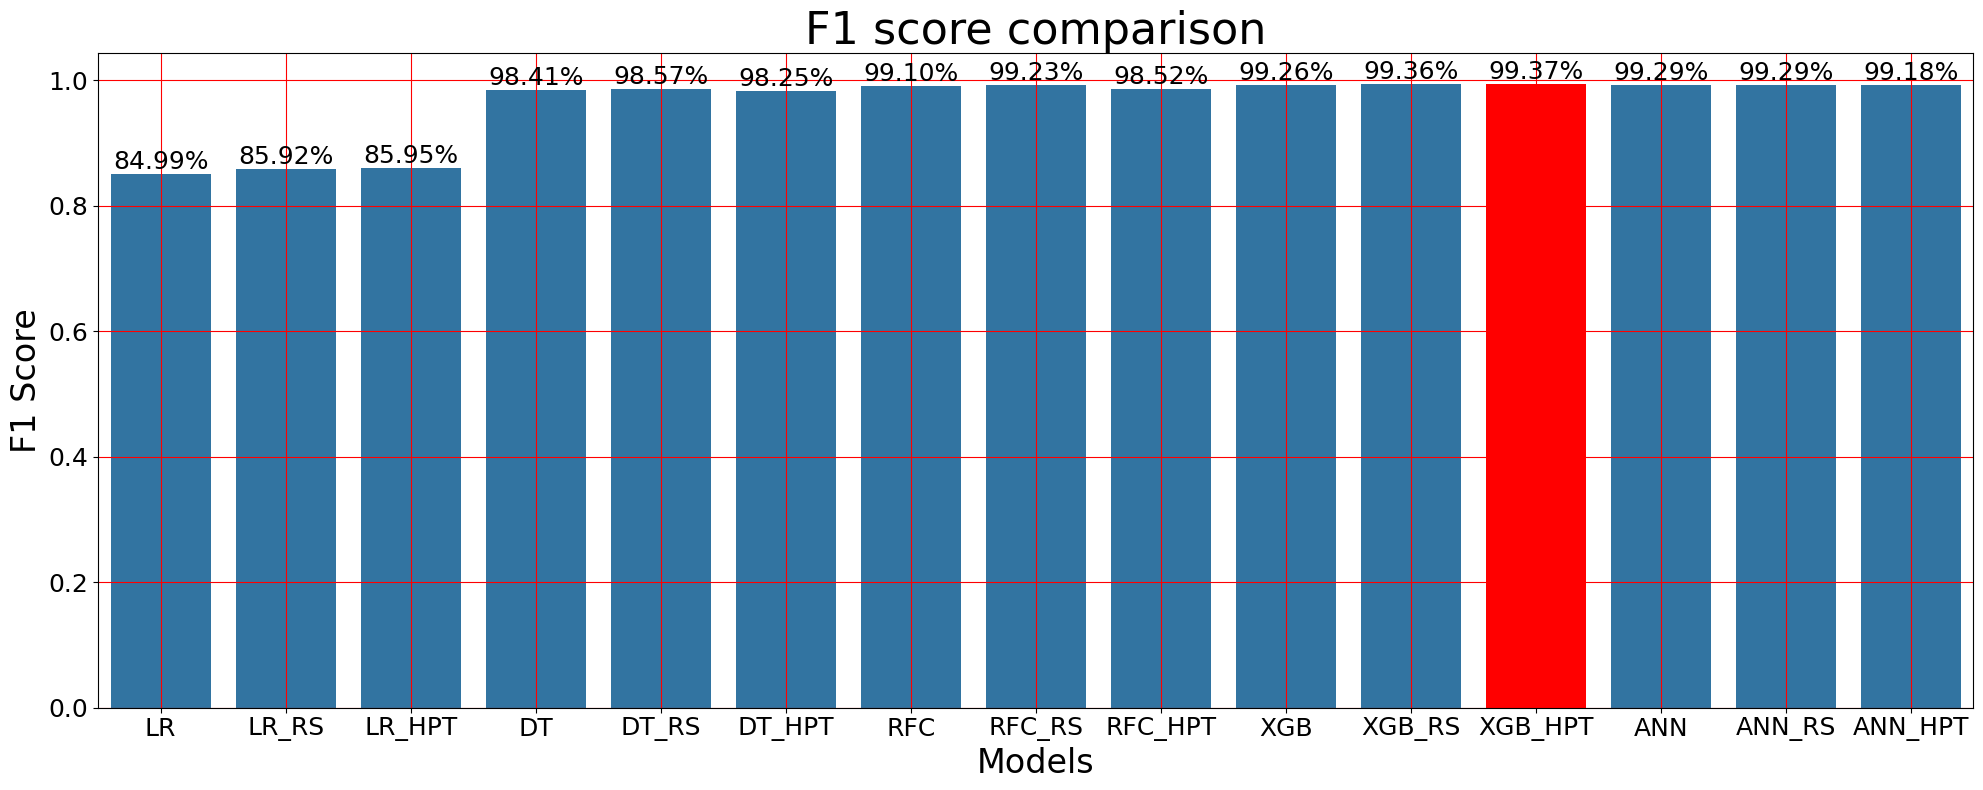

In [ ]:
plt.figure(figsize=(20,8))
F1_Score['Percentage'] = (F1_Score['F1Score']) * 100

ax = sns.barplot(x = 'Model_Name',y = 'F1Score', data=F1_Score)
# Add labels to the bars
for container in ax.containers:
    labels = [f'{v:.2f}%' for v in F1_Score['Percentage']]
    ax.bar_label(container,labels = labels,fontsize = 18)

# Highlight the bar with the maximum value
max_index = F1_Score['F1Score'].idxmax()
ax.patches[max_index].set_facecolor('red')

plt.grid(color='r')
plt.title('F1 score comparison',fontsize = 32)
plt.xlabel('Models',fontsize = 24)
plt.ylabel('F1 Score',fontsize = 24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

## **10.7.2 Visualization of Accuracy scores**

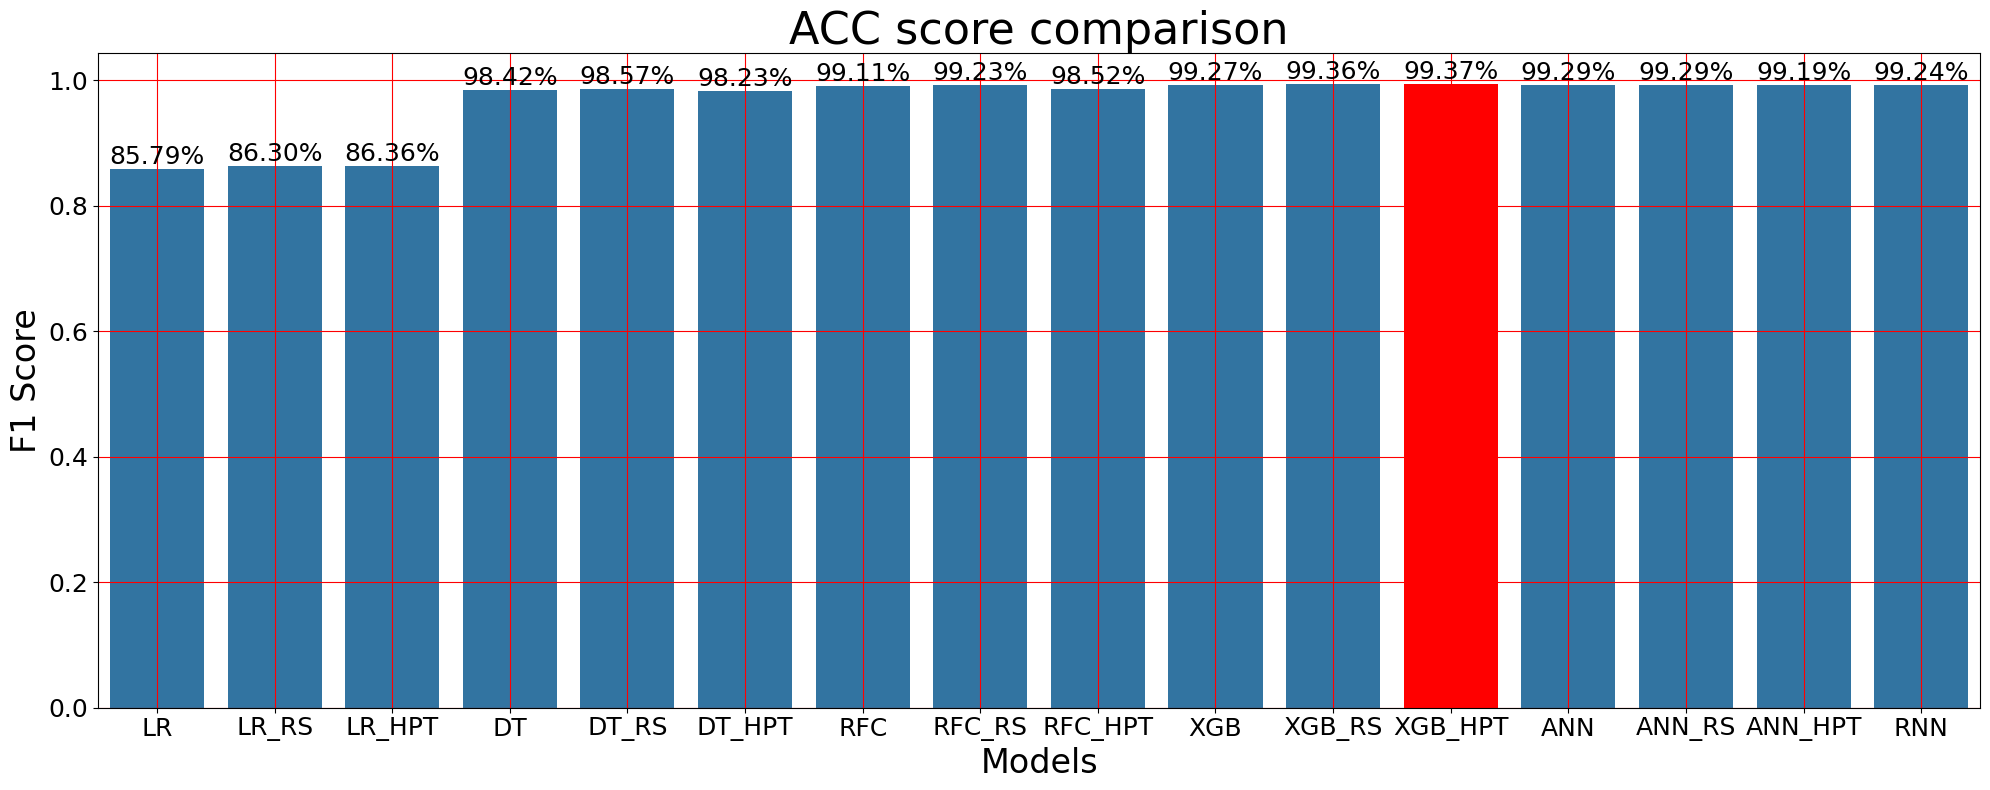

In [ ]:
plt.figure(figsize=(20,8))
Acc_Score['Percentage'] = (Acc_Score['AccScore']) * 100
ax = sns.barplot(x = 'Model_Name',y = 'AccScore', data=Acc_Score)
# Add labels to the bars
for container in ax.containers:
    labels = [f'{v:.2f}%' for v in Acc_Score['Percentage']]
    ax.bar_label(container,labels = labels,fontsize = 18)

# Highlight the bar with the maximum value
max_index = Acc_Score['AccScore'].idxmax()
ax.patches[max_index].set_facecolor('red')

# Plot the bar graph
plt.grid(color='r')
plt.title('ACC score comparison',fontsize = 32)
plt.xlabel('Models',fontsize = 24)
plt.ylabel('F1 Score',fontsize = 24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

# 10.8 Conclusion

**Logistic Regression:** This model achieved an accuracy score of 86.36. Though it is good score, we may explore other models for higher accuracy score.

**Decision Tree :** Accuracy score - 98.57

**Random Forest:** This model achieved an accuracy score of 99.23.

**XGBoost:** Similar to the Random Forest, XGBoost also scored 99.37 in accuracy. XGBoost is a powerful ensemble algorithm known for its high performance and is always a top choice.

**Artificial Neural Network (ANN):** The ANN model achieved an accuracy score of 99.29, which is quite impressive for classification tasks.

**Recurrent Neural Network (RNN):** Similar to XGBoost and Random Forest, RNN scored 99.24(above 99%) in accuracy.

From the above analysis, it is evident that **Random Forest, XGBoost, ANN and RNN models have accuracy score above 99**

Also Hyper parameter tuning for **Random Forest & ANN modes** shows slight decrease in accuracy score.

With that we conclude **XGBoost with an accuracy score of 99.37** is the best model for WalkRUN classification project.